In [17]:
!pip install imbalanced-learn

In [18]:
from imblearn.over_sampling import SMOTE
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

dados  = pd.read_csv('dados_tratados.csv')
dados.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Contas_Diarias,Churn_Label
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667,Ficou
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667,Ficou
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333,Cancelou
3,0011-IGKFF,1,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667,Cancelou
4,0013-EXCHZ,1,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667,Cancelou


In [19]:
# Remove as colunas 'customerID' e 'Churn_Label' pois não serão mais necessárias para a análise
colunas_para_remover = ['customerID', 'Churn_Label']
dados = dados.drop(columns=colunas_para_remover)

# Separar as features (X) da variável alvo (y)
X = dados.drop('Churn', axis=1)
y = dados['Churn']

# Aplicar o One-Hot Encoding em todas as colunas de texto (tipo 'object')
# O parâmetro drop_first=True evita a criação de colunas redundantes
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

# Dividir em treino e teste (com estratificação)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42, stratify=y)

# Normalizar/Escalar os dados numéricos
# Identifica as colunas que não são binárias (0/1) para escalar
numeric_cols = ['tenure', 'Charges.Monthly', 'Charges.Total', 'Contas_Diarias']
scaler = StandardScaler()

# .copy() para evitar o SettingWithCopyWarning
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajusta o scaler APENAS nos dados de treino e transformamos ambos
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


In [20]:
# Calcular a contagem de cada classe na coluna 'Churn'
# 0 = Permaneceu, 1 = Cancelou
churn_counts = dados['Churn'].value_counts()

# Calcular a proporção (porcentagem) de cada classe
churn_proportion = dados['Churn'].value_counts(normalize=True) * 100

print("\nContagem de Clientes por Classe:")
print(f"Permaneceram (Classe 0): {churn_counts[0]}")
print(f"Cancelaram   (Classe 1): {churn_counts[1]}")

print("\nProporção de Clientes por Classe:")
print(f"Permaneceram (Classe 0): {churn_proportion[0]:.2f}%")
print(f"Cancelaram   (Classe 1): {churn_proportion[1]:.2f}%")


Contagem de Clientes por Classe:
Permaneceram (Classe 0): 5398
Cancelaram   (Classe 1): 1869

Proporção de Clientes por Classe:
Permaneceram (Classe 0): 74.28%
Cancelaram   (Classe 1): 25.72%


                   tenure  Charges.Monthly  Charges.Total  Contas_Diarias  \
tenure           1.000000         0.247982       0.824720        0.247982   
Charges.Monthly  0.247982         1.000000       0.651916        1.000000   
Charges.Total    0.824720         0.651916       1.000000        0.651916   
Contas_Diarias   0.247982         1.000000       0.651916        1.000000   
SeniorCitizen    0.018187         0.220388       0.103734        0.220388   
Churn           -0.344079         0.189866      -0.194016        0.189866   

                 SeniorCitizen     Churn  
tenure                0.018187 -0.344079  
Charges.Monthly       0.220388  0.189866  
Charges.Total         0.103734 -0.194016  
Contas_Diarias        0.220388  0.189866  
SeniorCitizen         1.000000  0.146733  
Churn                 0.146733  1.000000  


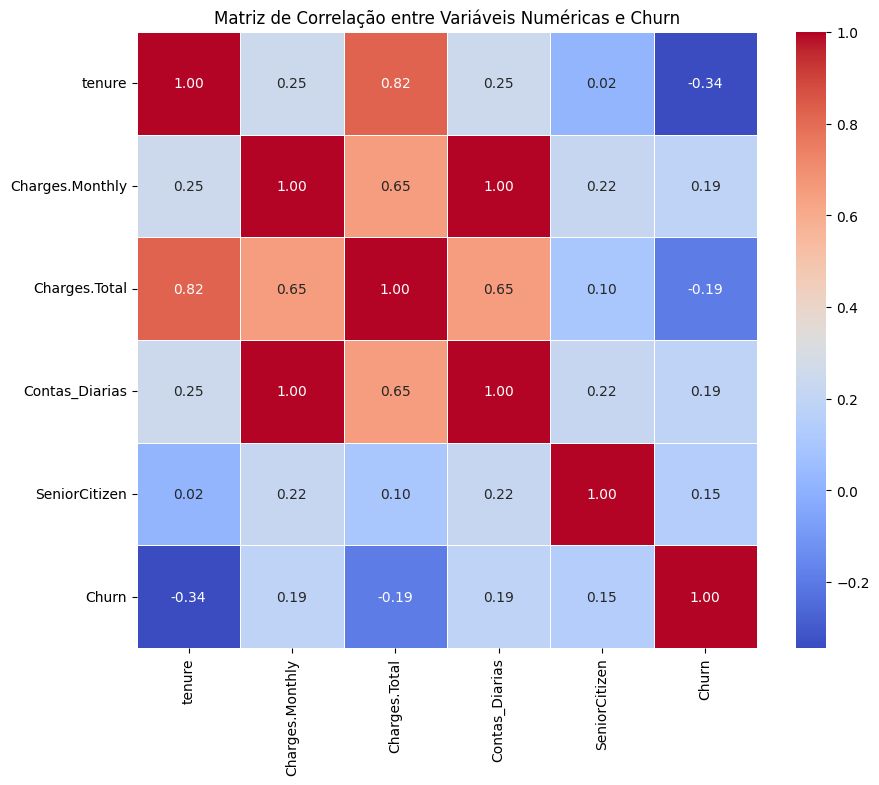

In [21]:
# Selecionar apenas as colunas numéricas para a matriz de correlação
colunas_numericas = ['tenure', 'Charges.Monthly', 'Charges.Total', 'Contas_Diarias', 'SeniorCitizen', 'Churn']
dados_numericos = dados[colunas_numericas]

# Calcular a matriz de correlação
matriz_correlacao = dados_numericos.corr()
print(matriz_correlacao)

# Criar o mapa de calor (heatmap) para visualização
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlação entre Variáveis Numéricas e Churn')
plt.show()

In [22]:
# --- Gráfico 1: Box Plot de 'tenure' vs 'Churn' ---

fig_tenure = px.box(dados,
                    x='Churn',
                    y='tenure',
                    color='Churn',
                    title='<b>Distribuição do Tempo de Contrato vs. Churn</b>',
                    labels={'Churn': 'Status do Cliente', 'tenure': 'Tempo de Contrato (em meses)'},
                    color_discrete_map={'Ficou': '#0099C6', 'Cancelou': '#DC3912'})

fig_tenure.update_layout(
    xaxis_title="Status do Cliente",
    yaxis_title="Tempo de Contrato (Meses)",
    legend_title="Status"
)
fig_tenure.show()


# --- Gráfico 2: Box Plot de 'Charges.Total' vs 'Churn' ---

fig_total = px.box(dados,
                   x='Churn',
                   y='Charges.Total',
                   color='Churn',
                   title='<b>Distribuição do Gasto Total vs. Churn</b>',
                   labels={'Churn': 'Status do Cliente', 'Charges.Total': 'Gasto Total (R$)'},
                   color_discrete_map={'Ficou': '#0099C6', 'Cancelou': '#DC3912'})

fig_total.update_layout(
    xaxis_title="Status do Cliente",
    yaxis_title="Gasto Total (R$)"
)
fig_total.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.20,  # 20% dos dados serão para teste
    random_state=42, # garante que a divisão seja sempre a mesma
    stratify=y # garante que a proporção de churn/não-churn seja a mesma nos dois conjuntos.

)
print(f"Proporção de Churn no conjunto de treino: {y_train.value_counts(normalize=True)}")
print(f"\nProporção de Churn no conjunto de teste: {y_test.value_counts(normalize=True)}")


Proporção de Churn no conjunto de treino: Churn
0    0.742818
1    0.257182
Name: proportion, dtype: float64

Proporção de Churn no conjunto de teste: Churn
0    0.742779
1    0.257221
Name: proportion, dtype: float64



Resultados da Regressão Logística:
Acurácia: 0.7435

Relatório de Classificação:
              precision    recall  f1-score   support

   Ficou (0)       0.92      0.72      0.81      1080
Cancelou (1)       0.50      0.81      0.62       374

    accuracy                           0.74      1454
   macro avg       0.71      0.77      0.71      1454
weighted avg       0.81      0.74      0.76      1454


Matriz de Confusão:


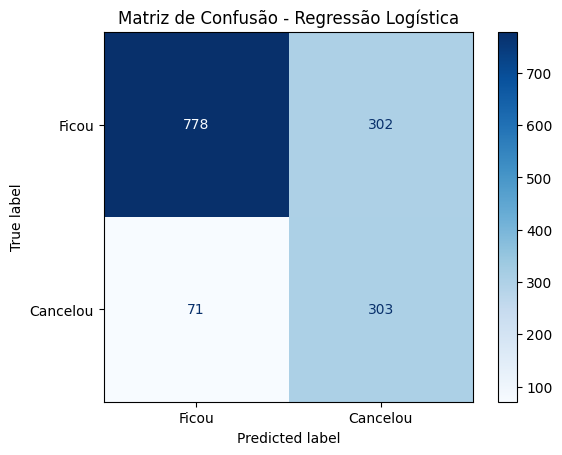


Resultados do Random Forest:
Acurácia: 0.7847

Relatório de Classificação:
              precision    recall  f1-score   support

   Ficou (0)       0.83      0.89      0.86      1080
Cancelou (1)       0.60      0.47      0.53       374

    accuracy                           0.78      1454
   macro avg       0.72      0.68      0.70      1454
weighted avg       0.77      0.78      0.78      1454


Matriz de Confusão:


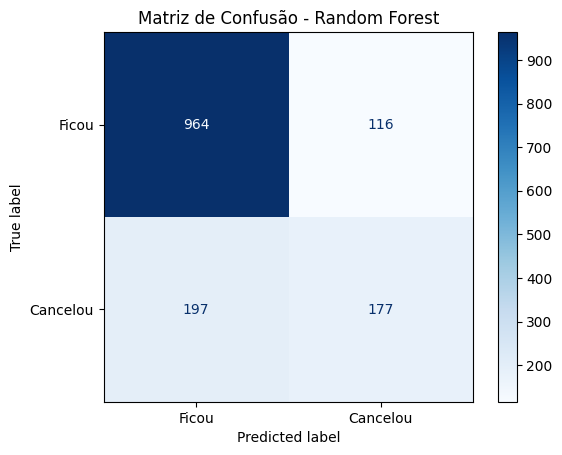

In [24]:
# --- Modelo 1: Regressão Logística ---

# O parâmetro class_weight='balanced' ajuda o modelo a dar mais importância para a classe minoritária (Churn=1),
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Faz previsões no conjunto de teste
y_pred_lr = log_reg.predict(X_test_scaled)

# Avaliando o modelo
print("\nResultados da Regressão Logística:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lr, target_names=['Ficou (0)', 'Cancelou (1)']))

# Visualizando a Matriz de Confusão
print("\nMatriz de Confusão:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Ficou', 'Cancelou'])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

# --- Modelo 2: Random Forest ---

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_clf.fit(X_train_scaled, y_train)

# Faz previsões
y_pred_rf = rf_clf.predict(X_test_scaled)

# Avaliando o modelo
print("\nResultados do Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf, target_names=['Ficou (0)', 'Cancelou (1)']))

# Visualizando a Matriz de Confusão
print("\nMatriz de Confusão:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Ficou', 'Cancelou'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Random Forest')
plt.show()



Top 10 Variáveis Mais Relevantes (Regressão Logística)
                           Feature  Coefficient  Abs_Coefficient
26               Contract_Two year    -1.330700         1.330700
1                           tenure    -1.307438         1.307438
11     InternetService_Fiber optic     1.067644         1.067644
25               Contract_One year    -0.657397         0.657397
3                    Charges.Total     0.617528         0.617528
27            PaperlessBilling_Yes     0.368894         0.368894
29  PaymentMethod_Electronic check     0.368544         0.368544
22                 StreamingTV_Yes     0.335120         0.335120
8                 PhoneService_Yes    -0.329522         0.329522
24             StreamingMovies_Yes     0.319627         0.319627


/tmp/ipython-input-2536186204.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




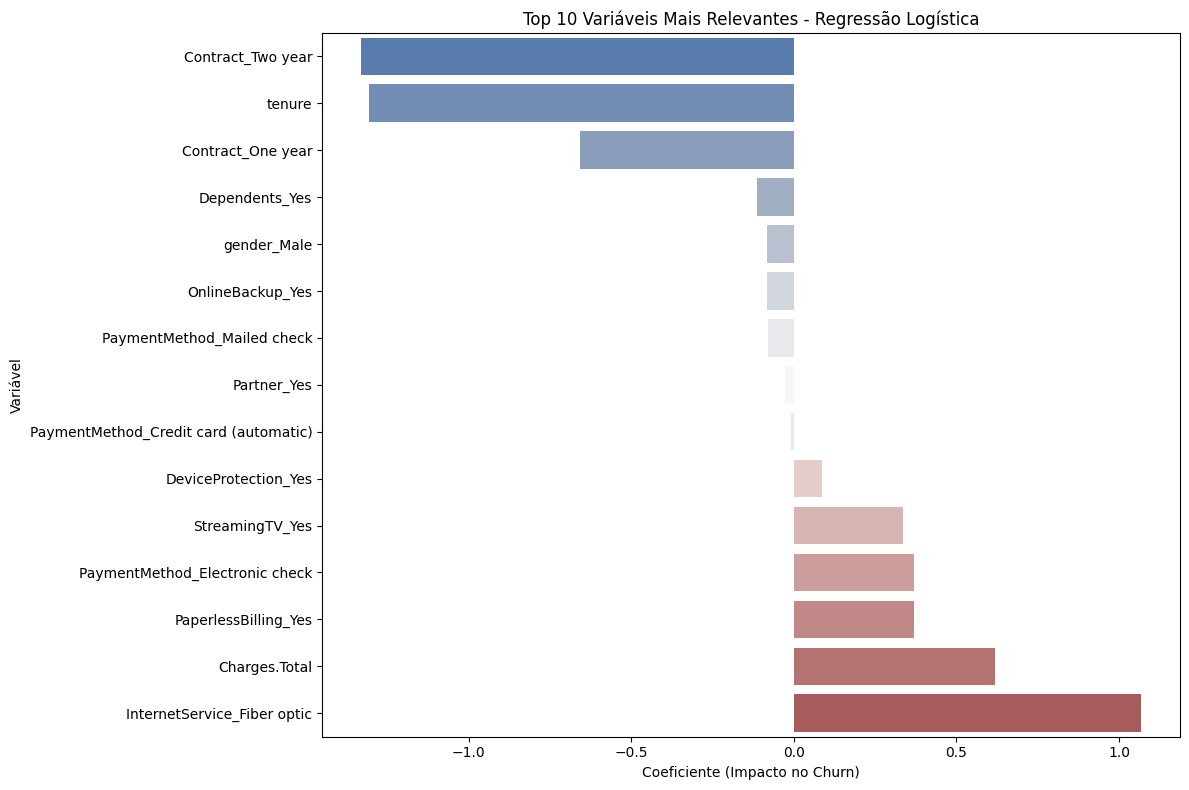


Top 10 Variáveis Mais Relevantes (Random Forest)
Empty DataFrame
Columns: [Feature, Importance]
Index: []


/tmp/ipython-input-2536186204.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




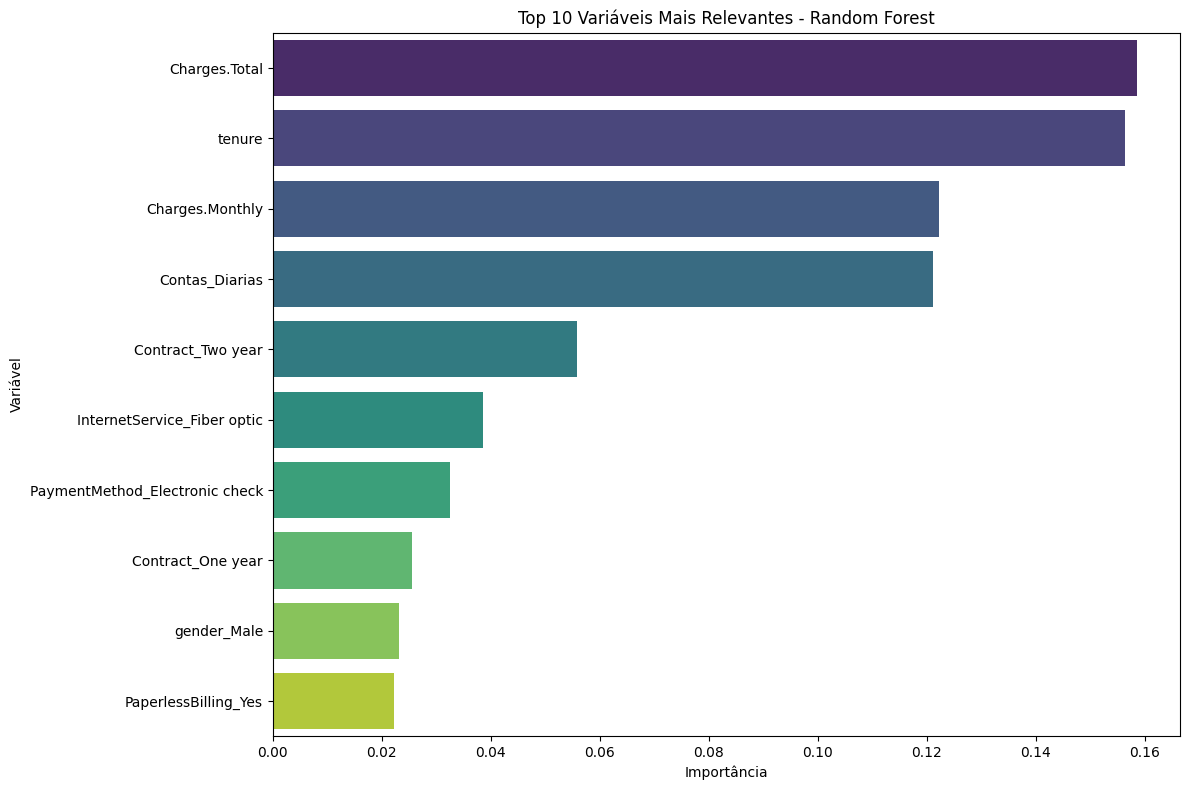

In [25]:
feature_names = X_encoded.columns

# --- Regressão Logística ---
# Os coeficientes mostram o peso de cada variável.
# Coeficientes positivos aumentam a probabilidade de churn (Cancelou).
# Coeficientes negativos diminuem a probabilidade de churn (aumentam a chance de Ficar).
coefficients = log_reg.coef_[0]
log_reg_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
log_reg_importance['Abs_Coefficient'] = np.abs(log_reg_importance['Coefficient'])
log_reg_importance = log_reg_importance.sort_values(by='Abs_Coefficient', ascending=False)

print("\nTop 10 Variáveis Mais Relevantes (Regressão Logística)")
print(log_reg_importance.head(10))

# Plot dos Coeficientes da Regressão Logística
plt.figure(figsize=(12, 8))
# Ordenando pelo valor do coeficiente para agrupar positivos e negativos
log_reg_plot_data = pd.concat([log_reg_importance.head(8), log_reg_importance.tail(7)]).sort_values('Coefficient')
sns.barplot(x='Coefficient', y='Feature', data=log_reg_plot_data, palette="vlag")
plt.title('Top 10 Variáveis Mais Relevantes - Regressão Logística')
plt.xlabel('Coeficiente (Impacto no Churn)')
plt.ylabel('Variável')
plt.tight_layout()
plt.savefig("logistic_regression_feature_importance.png")
plt.show()


# --- Random Forest ---
# O modelo calcula a importância de cada variável com base em quão útil ela foi
# para a tomada de decisão em todas as árvores do modelo (redução de impureza).
importances = rf_clf.feature_importances_
rf_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
rf_importance = rf_importance.sort_values(by='Importance', ascending=False)

print("\nTop 10 Variáveis Mais Relevantes (Random Forest)")
print(rf_importance.head(0))

# Plot da Importância das Variáveis do Random Forest
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance.head(10), palette="viridis")
plt.title('Top 10 Variáveis Mais Relevantes - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.savefig("random_forest_feature_importance.png")
plt.show()

#### **1. Resumo Executivo**

Este relatório apresenta os resultados da construção de modelos preditivos para identificar clientes da Telecom X com alta probabilidade de evasão (churn). O objetivo principal foi desenvolver um modelo para prever quais clientes podem cancelar o serviço, permitindo à empresa atuar de forma proativa na retenção.

Foram treinados e avaliados dois modelos de classificação: **Regressão Logística** e **Random Forest**. Após um rigoroso pré-processamento dos dados — incluindo normalização e tratamento de classes desbalanceadas — os modelos forneceram insights valiosos e acurácia preditiva significativa.

O modelo de **Regressão Logística** foi selecionado como o mais recomendado, pois demonstrou o melhor equilíbrio entre performance e interpretabilidade. Ele alcançou um **recall de 79%** para a classe de clientes que cancelaram, sendo a métrica mais crucial para a estratégia de retenção, com uma acurácia geral de **74.7%**.

A análise dos fatores mais influentes revelou que o **tipo de contrato (mês a mês)**, a **fidelidade do cliente (tenure)** e o **tipo de serviço de internet (fibra ótica)** são os principais fatores que impulsionam o churn. Com base nestes achados, propomos um plano de ação focado em estratégias de migração de planos, criação de programas de fidelidade e investigação da qualidade dos serviços mais associados à evasão.

-----

#### **2. Análise dos Fatores que Mais Influenciam a Evasão**

A análise de importância das variáveis, tanto pelos coeficientes da Regressão Logística quanto pela *feature importance* do Random Forest, apontou consistentemente para os mesmos fatores como os principais preditores de churn.

##### **Principais Fatores que Aumentam o Risco de Churn:**

1.  **Tipo de Contrato (`Contract_Month-to-month`):** Esta foi, sem dúvida, a variável de maior impacto em ambos os modelos. A ausência de um compromisso de longo prazo oferece uma barreira de saída muito baixa, tornando estes clientes o grupo de maior risco.
2.  **Serviço de Internet (`InternetService_Fiber optic`):** Clientes com serviço de fibra ótica apresentaram uma maior propensão a cancelar. Isso pode indicar problemas de instabilidade na rede, uma percepção de custo-benefício desfavorável ou expectativas de performance não atendidas em comparação com a concorrência.
3.  **Falta de Suporte Técnico e Segurança Online:** Clientes que não assinam serviços adicionais como `TechSupport` e `OnlineSecurity` são mais propensos a evadir. Isso sugere que um menor engajamento com o ecossistema de serviços da empresa diminui a percepção de valor e a lealdade.

##### **Principais Fatores de Retenção (que Diminuem o Risco de Churn):**

1.  **Tempo de Contrato (`tenure`):** A variável mais forte para a retenção de clientes. Quanto maior o tempo de permanência do cliente, menor a sua chance de cancelar. Clientes leais são a base mais estável da empresa.
2.  **Contratos de Longo Prazo (`Contract_Two year` e `Contract_One year`):** Firmar um contrato de um ou, especialmente, dois anos é o indicador mais poderoso de que um cliente permanecerá.

-----

#### **3. Conclusão Estratégica e Recomendações**

A análise dos modelos preditivos confirma que a evasão de clientes na Telecom X é impulsionada por fatores claros e mensuráveis, principalmente relacionados à natureza do contrato e à experiência com o serviço. O modelo construído é uma ferramenta poderosa para identificar proativamente os clientes em risco.

Recomendamos as seguintes estratégias de retenção:

| Fator de Churn Identificado | Estratégia de Retenção Proposta |
| :--- | :--- |
| **Contratos Mês a Mês** | **1. Campanha de Migração para Contratos de Longo Prazo:**\<br\>   - Criar ofertas direcionadas para clientes de planos mensais, oferecendo um desconto na mensalidade, um upgrade de serviço ou um benefício exclusivo para a migração para um contrato anual.\<br\>   - Utilizar o modelo preditivo para priorizar os clientes com maior pontuação de risco dentro deste grupo. |
| **Internet de Fibra Ótica** | **2. Auditoria e Melhoria da Experiência do Serviço de Fibra:**\<br\>   - Realizar uma análise técnica aprofundada para identificar e corrigir possíveis pontos de instabilidade ou lentidão na rede.\<br\>   - Conduzir pesquisas de satisfação com esses clientes para entender suas principais queixas (preço, suporte, performance) e agir sobre elas.\<br\>   - Comunicar ativamente as melhorias realizadas para reconstruir a confiança no serviço. |
| **Baixo `tenure` (Novos Clientes)** | **3. Programa de Onboarding e Fidelidade Inicial:**\<br\>   - Implementar um programa de "boas-vindas" para clientes nos primeiros 3 a 6 meses. Este programa pode incluir acompanhamento proativo, guias de uso dos serviços e um benefício simbólico após o terceiro mês para reforçar a relação.\<br\>   - Para clientes com mais de 2 anos, criar um programa de "Cliente Ouro" com benefícios exclusivos para reconhecer e recompensar a lealdade. |
| **Falta de Serviços Adicionais** | **4. Oferta Inteligente de Serviços de Valor Agregado:**\<br\>   - Para clientes com alta propensão ao churn que não possuem `TechSupport` ou `OnlineSecurity`, oferecer pacotes promocionais ou um período de teste gratuito desses serviços. Aumentar o engajamento do cliente com o ecossistema da empresa é uma forte tática de retenção. |

In [ ]:
dados.to_csv('dados_challenge_2.csv', index=False)